# Task 2

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import plot_confusion_matrix

In [73]:
np.random.seed(31415)

### Helper Functions

In [186]:
def scree_plot(title):
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    plt.figure(dpi=200)
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    
    
    plt.title(title)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')
    plt.tight_layout()
    
def pcplot2d(title):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2'])
    pc_df['class'] =labels
    
    plt.figure(dpi=200)
#     ax = sns.lmplot( x="PC1", y="PC2",
#       data=pc_df, 
#       fit_reg=False, 
#         hue='class', 
#       legend=True,
#       scatter_kws={"s": 80})
    sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="class", size=80, palette='deep')
    plt.title(title)
    plt.tight_layout()
    
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model, title='Title'):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4),dpi=200)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    plt.title(title)
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend(loc=(.6,0.08))

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred, average='micro')], 
               'Precision': [precision_score(y_test, ypred, average='micro')],
                'Recall': [recall_score(y_test, ypred, average='micro')]}
    results_df = pd.DataFrame(results)
    
    results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [75]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

def make_pose_dataset(raw_pose, num_subjects, augmented=False):
    pose_dataset = []
    pose_labels = []
    if augmented == False:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
    else:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
        for subject in range(num_subjects):
            for pose in range(21):
                img = raw_pose[1][:,pose,subject].reshape((40,48))
                img = np.flip(np.rot90(img)).reshape((48*40))
                pose_dataset.append(img)
                pose_labels.append(subject)
                
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.transpose(np.array(pose_labels))
    return pose_dataset, pose_labels

### load data and create dataset


In [76]:
#load data chunks
_, raw_pose, _ = load_data_chunks()

# Data Exploration

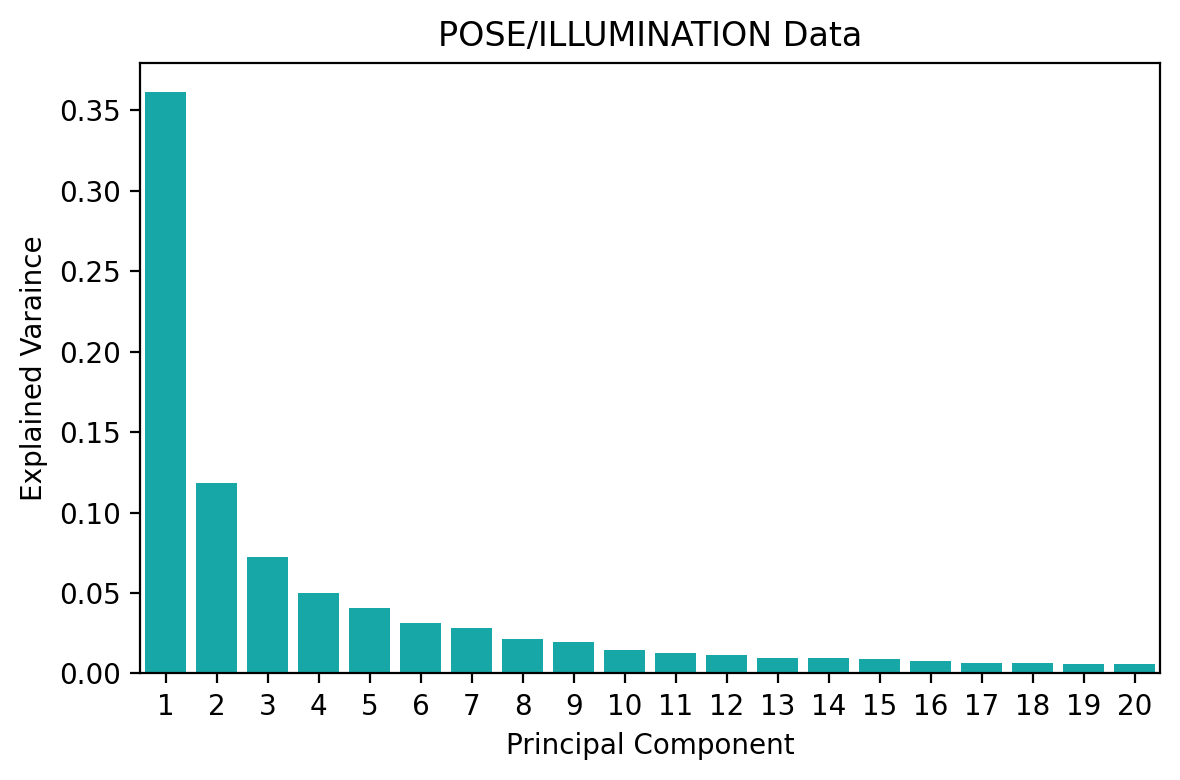

In [188]:
data, labels = make_pose_dataset(raw_pose, num_subjects=10, augmented=False)
scree_plot(title='POSE/ILLUMINATION Data')
plt.savefig('./graphics/pose_scree.png')

<Figure size 432x288 with 0 Axes>

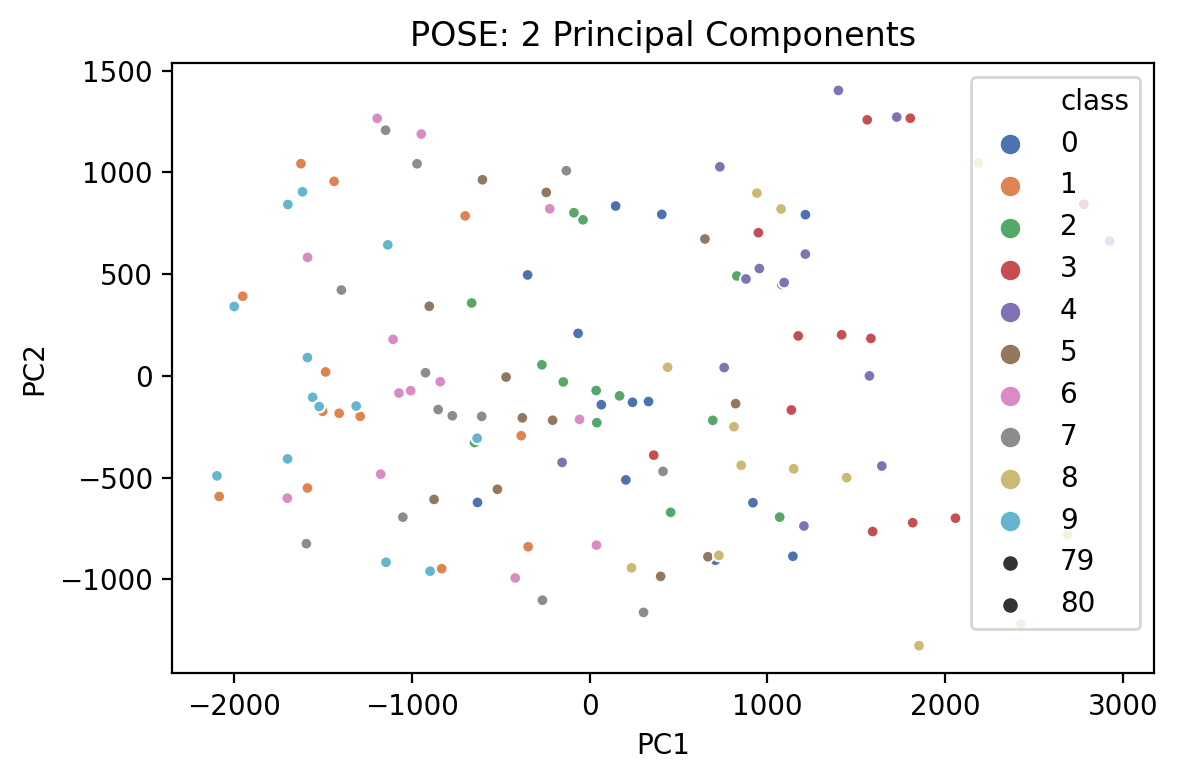

In [185]:
plt.figure()
pcplot2d(title='POSE: 2 Principal Components')
# plt.title('POSE: 2 Principal Components')
plt.savefig('./graphics/pose_pca_plot.png')

In [79]:
#The loops below create the two datasets dictionaries which will allow me to split the data into train and test for each desired number of subjects I would 
# like to experiment with. It also ensures that the same dataset is being used for KNN and Bayes in each experiment.
data_dict = {}
data_with_illum_dict = {}
for num_sub in [10, 20, 30, 40, 50, 60, 68]:
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub, augmented=False)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        shuffle='true', 
                                                        stratify=labels) 
    data_dict[num_sub] = (X_train, X_test, y_train, y_test)

for num_sub in [10, 20, 30, 40, 50, 60, 68]:
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub, augmented=True)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        shuffle='true', 
                                                        stratify=labels)

    data_with_illum_dict[num_sub] = (X_train, X_test, y_train, y_test)
    

# Gaussian Bayes

In [80]:
#the bayes training function does an exhaustive grid search for best # of principal components for each number of subjects
# and returns a training log and each of the trained models.
def bayes_training(data_dict):
    best_score = []
    best_params = []
    num_sub = [10, 20, 30, 40, 50, 60, 68]
    trained_models = []
    
    param_grid = {
    'pca__n_components': [i for i in range(1,200,2)]
    }
    
    for i in num_sub:
        
        X_train, X_test, y_train, y_test = data_dict[i]
        X_train = X_train/255
        X_test = X_test/255
        
        gnb = GaussianNB()
        pca = PCA()
        
        pipe = Pipeline(steps=[('pca', pca), ('bayes',gnb )])
        search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
        search.fit(X_train, y_train)
        best_score.append(search.best_score_)
        best_params.append(search.best_params_)
        trained_models.append(search)

    results_og = pd.DataFrame({'Number of Subjects':num_sub, 
                               'Best # of PC':[i['pca__n_components'] for i in best_params], 
                               'Best Training Score': best_score})
    
    return results_og, trained_models

# the testing function below takes the training results and models from the training functions and tests them with their corresponding dataset
# it returns a testing log and all of the 
def model_testing(trained_models, train_results, data_dict):
    test_accuracy = []
    num_sub = [10, 20, 30, 40, 50, 60, 68]
    for i in range(len(num_sub)):
        X_train, X_test, y_train, y_test = data_dict[num_sub[i]]
        X_test = X_test/255
        ypred = trained_models[i].predict(X_test)
        test_accuracy.append(accuracy_score(y_test, ypred))
    results = train_results
    results['Testing Accuracy'] = test_accuracy
    
    return results 

In [81]:
bayes_training1, bayes_models1 = bayes_training(data_dict)
bayes_testing1 = model_testing(bayes_models1, bayes_training1, data_dict)
bayes_testing1

,Number of Subjects,Best # of PC,Best Training Score,Testing Accuracy
0,10,57,0.823977,0.769231
1,20,81,0.709159,0.730769
2,30,139,0.640943,0.735043
3,40,145,0.626180,0.711538
4,50,137,0.639560,0.707692
5,60,159,0.611877,0.628205
6,68,113,0.569381,0.624060


In [82]:
bayes_training2, bayes_models2 = bayes_training(data_with_illum_dict)
bayes_testing2 = model_testing(bayes_models2, bayes_training2, data_with_illum_dict)
bayes_testing2

,Number of Subjects,Best # of PC,Best Training Score,Testing Accuracy
0,10,59,0.873670,0.843137
1,20,79,0.827588,0.818627
2,30,151,0.796907,0.790850
3,40,145,0.776252,0.757353
4,50,173,0.775630,0.717647
5,60,127,0.752092,0.750000
6,68,117,0.758948,0.739193


In [142]:
best_bayes30 = bayes_models2[2]
best_bayes10 = bayes_models2[0]

In [144]:
# training_plot(best_bayes30, title='POSE: Bayes 30 Subjects')
# plt.savefig('./graphics/pose_best_bayes_training_30_subject.png')

In [108]:
# x1, y1, = bayes_testing1['Number of Subjects'], bayes_testing1['Testing Accuracy']
# x2, y2, = bayes_testing2['Number of Subjects'], bayes_testing2['Testing Accuracy']

# plt.figure(dpi=200)
# plt.plot(x1,y1,c='orange',label ='Original Data')
# plt.plot(x2,y2, label='Augmented Data')
# plt.xlabel('Number of Subjects')
# plt.ylabel('Mean Accuracy Score')
# plt.title('Bayes Testing Accuracy')
# plt.legend()
# plt.savefig('./graphics/bayes_testing_accuracy_pose.png')

# KNN

In [84]:
def knn_training(data_dict):
    best_score = []
    best_params = []
    num_sub = [10, 20, 30, 40, 50, 60, 68]
    trained_models = []
    
    param_grid = {
            'pca__n_components': [i for i in range(1,250,5)],
            'knn__n_neighbors' : [i for i in range(1,21)],  
        }
    
    for i in num_sub:
        
        X_train, X_test, y_train, y_test = data_dict[i]
        X_train = X_train/255
        X_test = X_test/255
        pca = PCA()
        knn = KNeighborsClassifier()
        
        
        pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])
        
        search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
        search.fit(X_train, y_train)
        best_score.append(search.best_score_)
        best_params.append(search.best_params_)
        trained_models.append(search)
        
    results = pd.DataFrame({'Number of Subjects':num_sub, '# of Neighbors':[i['knn__n_neighbors'] for i in best_params],
                            '# of PC':[i['pca__n_components'] for i in best_params], 'Best Score': best_score})
    
    return results, trained_models


In [134]:
knn_train_results1, knn_models1 = knn_training(data_dict)
knn_test_results1 = model_testing(knn_models1, knn_train_results1, data_dict)
knn_test_results1

KeyboardInterrupt: 

In [86]:
knn_train_results2, knn_models2 = knn_training(data_with_illum_dict)
knn_test_results2 = model_testing(knn_models2, knn_train_results2, data_with_illum_dict)
knn_test_results2

,Number of Subjects,# of Neighbors,# of PC,Best Score,Testing Accuracy
0,10,1,131,0.827660,0.862745
1,20,1,186,0.777237,0.799020
2,30,1,231,0.731075,0.745098
3,40,1,166,0.728978,0.730392
4,50,1,231,0.736134,0.719608
5,60,1,246,0.722002,0.714052
6,68,1,241,0.691595,0.695965


In [107]:
# x1, y1, = knn_test_results1['Number of Subjects'], knn_test_results1['Testing Accuracy']
# x2, y2, = knn_test_results2['Number of Subjects'], knn_test_results2['Testing Accuracy']

# plt.figure(dpi=200)
# plt.plot(x1,y1,c='orange',label ='Original Data')
# plt.plot(x2,y2, label='Augmented Data')
# plt.xlabel('Number of Subjects')
# plt.ylabel('Mean Accuracy Score')
# plt.title('KNN Testing Accuracy')
# plt.legend()
# plt.savefig('./graphics/knn_testing_accuracy_pose.png')

In [135]:
best_knn30 = knn_models2[2]

In [136]:
data_with_illum_dict[30]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'pca__n_components': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                               46, 51, 56, 61, 66, 71, 76, 81,
                                               86, 91, 96, 101, 106, 111, 116,
                                               121, 126, 131, 136, 141, 146, ...]},
             scoring='accuracy')

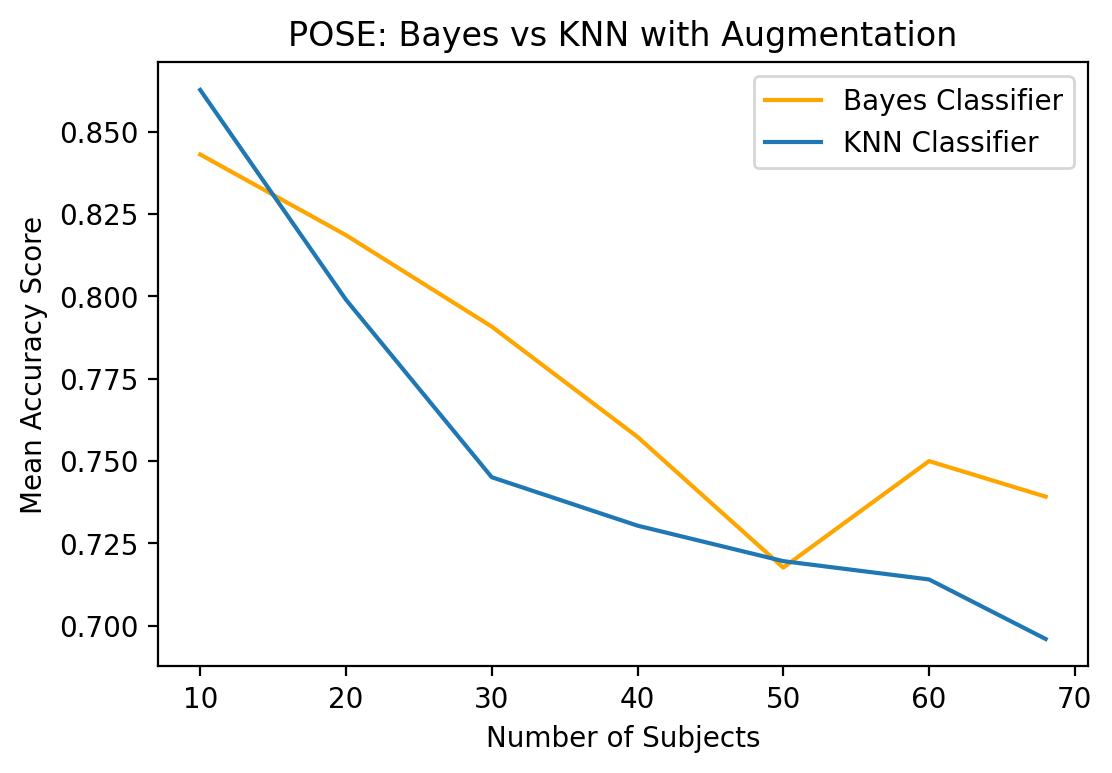

In [140]:
x1, y1, = bayes_testing2['Number of Subjects'], bayes_testing2['Testing Accuracy']
x2, y2, = knn_test_results2['Number of Subjects'], knn_test_results2['Testing Accuracy']

plt.figure(dpi=200)
plt.plot(x1,y1,c='orange',label ='Bayes Classifier')
plt.plot(x2,y2, label='KNN Classifier')
plt.xlabel('Number of Subjects')
plt.ylabel('Mean Accuracy Score')
plt.title('POSE: Bayes vs KNN with Augmentation')
plt.legend()
plt.savefig('./graphics/pose_bayes_vs_knn.png')